- TF-IDF : 텍스트 벡터화
- PCA : 차원 축소
- LSA : 잠재 의미 분석
- T-SNE : 2D 시각화
- 로지스틱회귀
- 토큰화 & 전치리


In [13]:
# LSA 는 TF-IDF 행렬에 대해서 SVD 를 적용.
# 단어와 문서 간의 숨겨진 의미 관계를 찾음.
# LSA : 문서 속 단어들의 숨은 의미 관계를 찾아내는 통계적 기법
# PCA : 데이터 자체를 분산하여 최대화.
# “고양이”와 “사료”가 자주 함께 등장하고 “강아지”와 “사료”도 자주 함께 등장한다면 → “고양이”와 “강아지”는 비슷한 의미를 가진다고 보는 거야.
# "은행" 이라는 단어로만 봤을때, "돈" , "계좌" , "통장" 등 주변에 등장 or "나무","냄새","먹는다","음식" 등 주변에 등장

In [14]:
# T-SNE : 고차원 데이터를 2D/3D로 변환 - 시각화 전용 (분석에는 부적합) , 계산이 오래걸림.
# PCA vs T-SNE
# PCA : 속도가 빠르고 전역 구조 보존
# T-SNE : 속도가 느리고, 국소(지역) 군집 명확

In [15]:
# 데이터셋
from sklearn.datasets import load_files
train_path = r'/Users/kangminji/LLM/20news-bydate-train'
test_path = r'/Users/kangminji/LLM/20news-bydate-test'
newsgroups_train = load_files(train_path,encoding='latin1')
newsgroups_test = load_files(test_path,encoding='latin1')
categories =  ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
import re

def clean_text(text):
    # 헤더 제거
    text = re.sub(r'^From:.*\n', '', text, flags=re.MULTILINE)
    text = re.sub(r'^Subject:.*\n', '', text, flags=re.MULTILINE)

    # 풋터 제거
    text = re.sub(r'\n--\n.*$', '', text, flags=re.DOTALL)

    # 인용문 제거
    text = re.sub(r'(^|\n)[>|:].*', '', text)

    return text
# 카테고리 제거
def filter_categories(dataset, categories):
    target_names = dataset.target_names
    selected_idx = [ target_names.index(c) for c in categories  ]
    #필터링
    data_filtered, target_filtered = [], []
    for text,label in zip(dataset.data, dataset.target):
        if label in selected_idx:
            new_label = selected_idx.index(label)  # 라벨 재 정렬
            data_filtered.append(text) ; target_filtered.append( new_label  )
    return data_filtered,target_filtered,categories
train_data, train_target, target_names = filter_categories(newsgroups_train,categories)
test_data, test_target, _ = filter_categories(newsgroups_test,categories)

x_train = [ clean_text(t) for t in train_data]
x_test = [ clean_text(t) for t in test_data]
y_train = train_target
y_test = test_target

In [16]:
# 텍스트 전처리 (소문자 + 토큰화(3글자이상) + 불용어제거(stopwords) + 어간추출(steming)) --> 영어
# 파이프라인

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


regtok = RegexpTokenizer(r"[\w']{3,}")
english_stops = set(stopwords.words('english'))

# 커스텀 토크나이저
def tokenizer(text):
    tokens = regtok.tokenize(text)
    words = [ word for word in tokens if word not in english_stops ]
    features = list(map(lambda x : PorterStemmer().stem(x),words))
    return features

# TF-IDF 백터화
tfidf = TfidfVectorizer(tokenizer=tokenizer , max_features=2000, min_df=2 , max_df=0.5)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.fit_transform(x_test)

# 분류모델
lr_clf = LogisticRegression(max_iter=200,random_state=42)
lr_clf.fit(x_train_tfidf,y_train)

print('-- 기본분류 ------------')
print(f'학습정확도 : {lr_clf.score(x_train_tfidf , y_train)}')
print(f'테스트정확도 : {lr_clf.score(x_test_tfidf , y_test)}')

print('주성분 분석')


# 데이터의 분산이 가장 큰 방향
# 선형 변환만 가능
# 모든 데이터의 특성을 평등하게 고려
# 용도 : 시각화 , 속도 계산
# 2000차원 -> 100차원으로 축소

from sklearn.decomposition import PCA
pca = PCA(n_components=100 , random_state=45)
x_train_pca = pca.fit_transform(x_train_tfidf.toarray())
x_test_pca = pca.transform(x_test_tfidf.toarray())

import numpy as np

cumsum_var = np.cumsum( pca.explained_variance_ratio_ )

print(f'원본 차원 : {x_train_tfidf.shape[1]}')
print(f'축소 후 차원 : {x_train_pca.shape[1]}')
print(f'축소 후 차원 : {pca.explained_variance_.sum()}')
print(f'누적 분산 : {cumsum_var[:10]}')

# pca 후 분류
lr_clf_pca = LogisticRegression(max_iter=200,random_state=42)
lr_clf_pca.fit(x_train_pca,y_train)

print('-- 주성분 분석 분류 ------------')
print(f'학습정확도 : {lr_clf_pca.score(x_train_pca , y_train)}')
print(f'테스트정확도 : {lr_clf_pca.score(x_test_pca , y_test)}')



/Users/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


-- 기본분류 ------------
학습정확도 : 0.9705014749262537
테스트정확도 : 0.3348115299334812
주성분 분석
원본 차원 : 2000
축소 후 차원 : 100
축소 후 차원 : 0.32831757715124954
누적 분산 : [0.01211923 0.02229888 0.03189694 0.04138118 0.0493389  0.05676164
 0.0635188  0.0701598  0.0765997  0.0826845 ]
-- 주성분 분석 분류 ------------
학습정확도 : 0.8962635201573255
테스트정확도 : 0.35033259423503327


In [17]:
# T-SNE 2D 시각화
# 고차원 데이터를 2D / 3D 변환
# 비슷한 데이터는 가깝게 , 다른 데이터는 멀리 배치
# 계산이 오래 걸리지만 시각화 효과가 뛰어남
# 주의 : 분석용이 아니라 시각화 전용임 !!

In [18]:
# lsa  잠재적 의미분석
# tf-idf svd
# PCA보다 의미론적 관계 잘 포착
# 테스트 데이터에 효과적
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100,random_state=42)
x_train_lsa = svd.fit_transform(x_train_tfidf)
x_test_lsa = svd.transform(x_test_tfidf)

print(f'원본 차원 : {x_train_tfidf.shape[1]}')
print(f'축소후 차원 : {x_train_lsa.shape[1]}')
print(f'설명된 분산 : {svd.explained_variance_.sum()}')

# lsa 후 분류
lr_clf_lsa = LogisticRegression(max_iter=200,random_state=42)
lr_clf_lsa.fit(x_train_lsa,y_train)

print('주성분 분석 분류------------')
print(f'학습정확도 : {lr_clf_lsa.score(x_train_lsa,y_train)}')
print(f'테스트정확도 : {lr_clf_lsa.score(x_test_lsa,y_test)}')

원본 차원 : 2000
축소후 차원 : 100
설명된 분산 : 0.32595187999734454
주성분 분석 분류------------
학습정확도 : 0.9016715830875123
테스트정확도 : 0.3473762010347376


In [19]:
# LSA 기반 유사도 분석
# 코사인 유사도  0(완전히 다름) ~ 1(같음)
# LSA 의미기반 유사도
# 첫번재 문서의 유사 문서 찾기

from sklearn.metrics.pairwise import cosine_similarity
sim_result =  cosine_similarity([x_train_lsa[0]], x_train_lsa)
sim_index = (-sim_result[0]).argsort()[:20]
print(f'원문 카테고리 :{newsgroups_train.target_names[y_train[0]]}')
print(f'상위 유사도 : {sorted(sim_result[0],reverse=True)[:5]}')
similar_categorys =  [newsgroups_train.target_names[y_train[i]] for i in sim_index]
print(f'유사 문서들의 카테고리 : {similar_categorys[:10]}')

원문 카테고리 :alt.atheism
상위 유사도 : [np.float64(1.0000000000000004), np.float64(0.8316829609917081), np.float64(0.8121930416748515), np.float64(0.6969874196709019), np.float64(0.6300822612803982)]
유사 문서들의 카테고리 : ['alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism']


In [20]:
from sklearn.manifold import TSNE
# perplexity 이웃개수 조절 
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tnse_lsa = tsne.fit_transform(x_train_lsa)
print(f'입력 차원 : {x_train_lsa.shape[1]}')
print(f'출력 차원 : {tnse_lsa.shape}')

입력 차원 : 100
출력 차원 : (2034, 2)


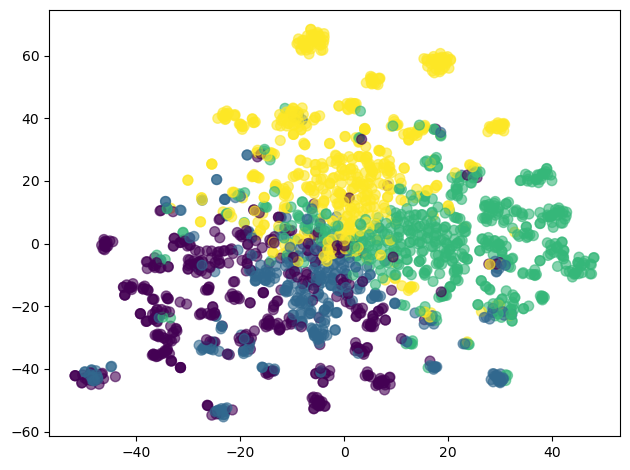

In [21]:
import matplotlib.pyplot as plt
colors = y_train[:len(tnse_lsa)]
plt.scatter(tnse_lsa[:,0],tnse_lsa[:,1],c = colors, cmap='viridis',alpha=0.6,s=50)
plt.tight_layout()
plt.show()

| 구분         | 개념 요약                                           | 장점                             | 단점                                     | 주요 용도                       | 정확도              | 속도       | 시각화 필요성                 |
| ---------- | ----------------------------------------------- | ------------------------------ | -------------------------------------- | --------------------------- | ---------------- | -------- | ----------------------- |
| **TF-IDF** | 단어의 등장 빈도와 중요도를 수치로 표현하는 **기초 표현 방식**           | 간단하고 해석 쉬움<br>기본 분류기에 바로 사용 가능 | 단어 간 **의미 관계 반영 불가**<br>희소(sparse) 데이터 | 텍스트 분류, 스팸 탐지, 감성 분석        | 중간~높음 (단어 기반일 때) | 빠름 ⚡     | 낮음 (주로 수치 기반)           |
| **PCA**    | 분산이 큰 방향으로 데이터를 축소하는 **선형 차원 축소**               | 계산 빠르고<br>잡음 제거, 과적합 완화        | **의미 정보 손실** 큼<br>비선형 데이터엔 부적합         | 수치형 데이터 차원 축소, 전처리          | 중간 (정보 일부 손실)    | 매우 빠름 ⚡⚡ | 중간 (2D 시각화 가능)          |
| **LSA**    | TF-IDF + SVD로 단어 간 **잠재 의미**를 찾아내는 **의미 기반 축소** | 유사 단어/문서 인식 가능<br>검색·추천에 유용    | 계산량 많음<br>희소 데이터에서 메모리 부담              | 문서 의미 비교, 검색엔진, 주제 분석       | 높음 (의미 유사성 반영)   | 중간 ⚙️    | 중간 (의미 공간 시각화용)         |
| **t-SNE**  | 데이터의 **비선형 관계**를 저차원(2D/3D)으로 시각화               | 고차원 데이터 시각화에 탁월<br>클러스터 패턴 명확  | **매우 느림** ⏳<br>정량분석엔 부적합               | 시각화, 군집 탐색, feature insight | 낮음 (분류엔 부적합)     | 느림 ⏳     | 매우 높음 🔥 (2D/3D 시각화 필수) |


### 🧠 핵심 요약 정리
#### TF-IDF: 단어의 빈도 기반 “기초 표현”.
- → 빠르지만 의미적 유사성은 못 잡음.
#### PCA: 수치형 데이터용 “선형 차원 축소”.
- → 과적합 완화엔 좋지만, 언어 의미는 손실됨.
#### LSA: TF-IDF를 기반으로 의미 공간을 학습하는 차원 축소.
- → 비슷한 의미의 단어·문장을 잘 묶음.
#### t-SNE: 고차원 데이터를 눈으로 보여주기 위한 시각화용.
- → 모델 성능보다는 “데이터 구조 이해”에 초점.


| 단계             | 사용 방법         | 목적              |
| -------------- | ------------- | --------------- |
| ① TF-IDF       | 문장을 숫자로 변환    | 기본 텍스트 표현       |
| ② LSA (또는 PCA) | 차원 축소 및 의미 반영 | 성능 향상, 과적합 방지   |
| ③ t-SNE        | 결과 시각화        | 군집 구조, 의미 공간 확인 |

### 👉 정리하자면
#### TF-IDF는 입력 준비, PCA/LSA는 압축과 의미추출, t-SNE는 눈으로 확인용
#### 정확도를 높이려면 LSA,
#### 속도를 높이려면 PCA,
#### 구조를 보고 싶다면 t-SNE가 제일 좋음

In [ ]:
# 한국어 데이터
import pandas as pd
url = "https://drive.google.com/uc?id=1KOKgZ4qCg49bgj1QNTwk1Vd29soeB27o"
df = pd.read_csv(url)

### 🧩 문장 데이터를 머신러닝 모델에 넣는 전체 흐름

#### 📘 단계별 설명
1. **문장 데이터**  
   - 텍스트(리뷰, 기사, 댓글 등)를 수집한다.

2. **토큰화(Tokenization)**  
   - 문장을 단어 단위로 나눈다.  
   - 한국어의 경우 `Okt` 형태소 분석기 사용.

3. **불용어 제거(Stopwords)**  
   - 의미 없는 조사, 접속사 등을 제거해 데이터 품질을 높인다.

4. **벡터화(Vectorization)**  
   - 단어를 숫자로 변환해 모델이 이해할 수 있도록 한다.  
   - `BoW`(단어 빈도 기반) 또는 `TF-IDF`(단어 중요도 반영) 방식 사용.

5. **분류 모델 학습(Training)**  
   - 예: `LogisticRegression`, `SVM`, `NaiveBayes` 등  
   - 데이터를 학습시켜 패턴을 찾는다.

6. **평가(Evaluation)**  
   - 예측 정확도, F1-score 등으로 모델 성능을 평가한다.

